<a href="https://colab.research.google.com/github/rhwogus/AI_lab/blob/main/LAB-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [8]:
# Load California Housing dataset
data = fetch_california_housing()

# Extract features and target
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data.feature_names}")
print(f"Target: Median house value (in $100,000s)")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min() * 100000:.2f}")
print(f"  Max: ${y.max() * 100000:.2f}")
print(f"  Mean: ${y.mean() * 100000:.2f}")

Dataset Information:
Number of samples: 20640
Number of features: 8

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)

Target statistics:
  Min: $14999.00
  Max: $500001.00
  Mean: $206855.82


In [9]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 16512 samples
Test set size: 4128 samples

✓ Data normalized (mean=0, std=1)


In [10]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 258
Number of test batches: 65


In [11]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


In [12]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


In [13]:
# Training parameters
num_epochs = 100

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 0.3203 | Test Loss: 0.3235
Epoch [20/100] | Train Loss: 0.2904 | Test Loss: 0.3036
Epoch [30/100] | Train Loss: 0.2752 | Test Loss: 0.3040
Epoch [40/100] | Train Loss: 0.2681 | Test Loss: 0.2858
Epoch [50/100] | Train Loss: 0.2598 | Test Loss: 0.2819
Epoch [60/100] | Train Loss: 0.2544 | Test Loss: 0.2866
Epoch [70/100] | Train Loss: 0.2516 | Test Loss: 0.2816
Epoch [80/100] | Train Loss: 0.2454 | Test Loss: 0.2720
Epoch [90/100] | Train Loss: 0.2426 | Test Loss: 0.2804
Epoch [100/100] | Train Loss: 0.2378 | Test Loss: 0.2728
------------------------------------------------------------
Training complete!


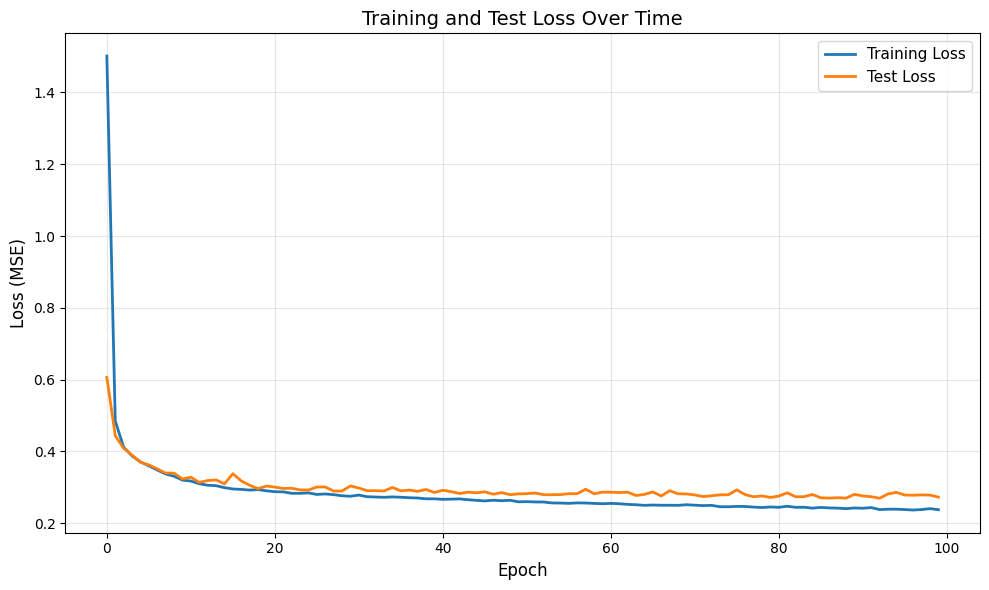

Final Training Loss: 0.2378
Final Test Loss: 0.2728


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [15]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  0.2733
Root Mean Squared Error (RMSE): 0.5227
Mean Absolute Error (MAE): 0.3569
R² Score: 0.7915

Interpretation:
On average, predictions are off by $35689.19
Model explains 79.15% of the variance in house prices


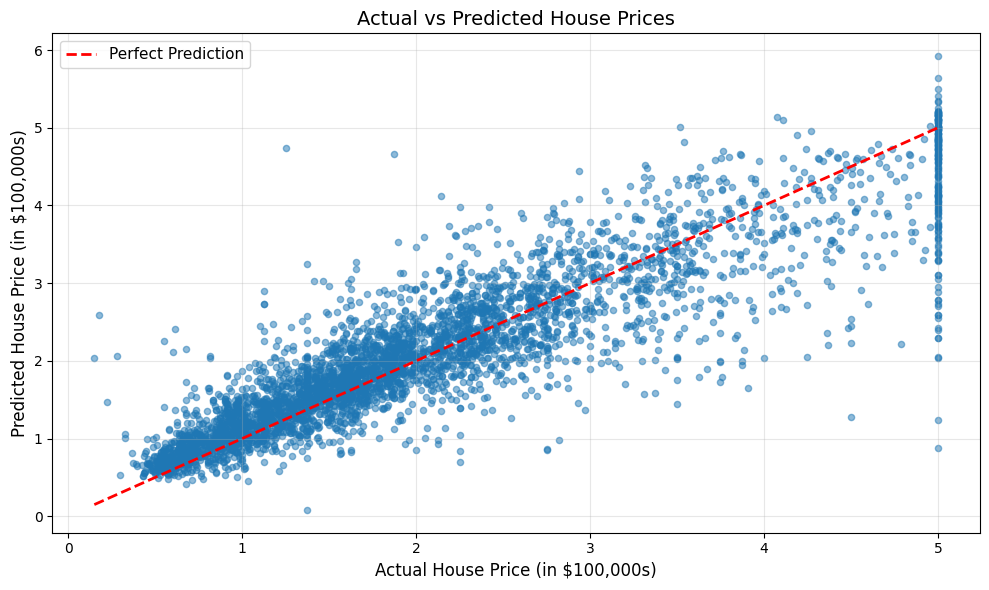


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$    47,700 | $    58,942 | $   -11,242
$    45,800 | $    73,624 | $   -27,824
$   500,001 | $   460,492 | $    39,509
$   218,600 | $   245,022 | $   -26,422
$   278,000 | $   292,612 | $   -14,612
$   158,700 | $   171,338 | $   -12,638
$   198,200 | $   235,478 | $   -37,278
$   157,500 | $   175,265 | $   -17,765
$   340,000 | $   236,978 | $   103,022
$   446,600 | $   466,467 | $   -19,867


In [16]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")
# 빨간선에 모여있어야 좋음

In [17]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


In [35]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 9.5 MB/s eta 0:00:00


In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from skorch import NeuralNetRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:

# Set device for parallel processing w/ GPUs

if torch.cuda.is_available() == True:
    print('Device set to CUDA...')
    device = torch.device('cuda')

Device set to CUDA...


In [39]:
# Create Pandas DataFrame for data manipulation & processing

from google.colab import files

# 📌 코랩 파일 업로드 창 띄우기
uploaded = files.upload()

# 업로드한 파일명 자동 확인
filename = list(uploaded.keys())[0]
print("업로드된 파일:", filename)

import pandas as pd

# 📌 업로드한 CSV 파일 읽기
df = pd.read_csv(filename)

df.head()


Saving student_habits_performance.csv to student_habits_performance (1).csv
업로드된 파일: student_habits_performance (1).csv


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [40]:
# Prepare dataset for normalizing

df = df.drop(columns=['student_id', 'gender', 'parental_education_level'])
df_one_hot = pd.get_dummies(df)
df_one_hot = df_one_hot.astype('float64')

df_one_hot.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,part_time_job_No,part_time_job_Yes,diet_quality_Fair,diet_quality_Good,diet_quality_Poor,internet_quality_Average,internet_quality_Good,internet_quality_Poor,extracurricular_participation_No,extracurricular_participation_Yes
0,23.0,0.0,1.2,1.1,85.0,8.0,6.0,8.0,56.2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,20.0,6.9,2.8,2.3,97.3,4.6,6.0,8.0,100.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,21.0,1.4,3.1,1.3,94.8,8.0,1.0,1.0,34.3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,23.0,1.0,3.9,1.0,71.0,9.2,4.0,1.0,26.8,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,19.0,5.0,4.4,0.5,90.9,4.9,3.0,1.0,66.4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:
# Round Data
df_one_hot['exam_score'] = np.round(df_one_hot['exam_score'])

# Ensure Dataset is ready for normalizing. Checking no nan values & all dtypes are the same
print(df_one_hot.info())
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                1000 non-null   float64
 1   study_hours_per_day                1000 non-null   float64
 2   social_media_hours                 1000 non-null   float64
 3   netflix_hours                      1000 non-null   float64
 4   attendance_percentage              1000 non-null   float64
 5   sleep_hours                        1000 non-null   float64
 6   exercise_frequency                 1000 non-null   float64
 7   mental_health_rating               1000 non-null   float64
 8   exam_score                         1000 non-null   float64
 9   part_time_job_No                   1000 non-null   float64
 10  part_time_job_Yes                  1000 non-null   float64
 11  diet_quality_Fair                  1000 non-null   float6

In [42]:
# Create independent (X) & dependent (Y) for training

X = df_one_hot.drop(columns=['exam_score'])
y = df_one_hot['exam_score']
print(f'X Size: {X.shape}')
print(f'y Size: {y.shape}')

print(f'X Columns: {X.columns}')

X Size: (1000, 18)
y Size: (1000,)
X Columns: Index(['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
       'attendance_percentage', 'sleep_hours', 'exercise_frequency',
       'mental_health_rating', 'part_time_job_No', 'part_time_job_Yes',
       'diet_quality_Fair', 'diet_quality_Good', 'diet_quality_Poor',
       'internet_quality_Average', 'internet_quality_Good',
       'internet_quality_Poor', 'extracurricular_participation_No',
       'extracurricular_participation_Yes'],
      dtype='object')


In [43]:
# Split dataset to prevent data leakage & proper training

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (800, 18)
X_test Shape: (200, 18)
y_train Shape: (800,)
y_test Shape: (200,)


In [44]:
# Scale data properly

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),
                              columns=X_test.columns, index=X_test.index)

print(X_train_scaled[:1])

          age  study_hours_per_day  social_media_hours  netflix_hours  \
349  0.857143             0.695122               0.125       0.222222   

     attendance_percentage  sleep_hours  exercise_frequency  \
349               0.754545     0.390625            0.833333   

     mental_health_rating  part_time_job_No  part_time_job_Yes  \
349              0.666667               1.0                0.0   

     diet_quality_Fair  diet_quality_Good  diet_quality_Poor  \
349                0.0                0.0                1.0   

     internet_quality_Average  internet_quality_Good  internet_quality_Poor  \
349                       1.0                    0.0                    0.0   

     extracurricular_participation_No  extracurricular_participation_Yes  
349                               1.0                                0.0  


In [45]:
# Creating the custom PyTorch Dataset
# Convert input DataFrames, convert to NumPy, then conver to tensors.

class customDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.to_numpy(dtype='float32')
        self.y = y.to_numpy(dtype='float32')


        if torch.cuda.is_available() == True:

            self.X = torch.tensor(self.X).to(device)
            self.y = torch.tensor(self.y).reshape(-1, 1).to(device)
            print(f'Inputs sent to CUDA device')

        else:

            self.X = torch.from_numpy(self.X)
            self.y = torch.from_numpy(self.y).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [47]:
# Create training function
def train_model(model, num_epochs, data_loader, losses, r2_score_list):

    # Creating our training loop

    model.train()

    for epoch in range(num_epochs):
        for i, (X_data, y_data) in enumerate(data_loader):

            # Clear gradients
            optimizer.zero_grad()

            # Calculate predictions
            y_pred = model(X_data)

            # Calculate loss
            loss = criterion(y_pred, y_data)

            # Calculate gradients
            loss.backward()

            # Update weights
            optimizer.step()

            # Make data numpy arrays for R^2 Score calculation
            y_pred = y_pred.cpu().detach().numpy()
            y_data = y_data.cpu().detach().numpy()

            r2_score_item = r2_score(np.array(y_pred), np.array(y_data))

        # Update losses list
        losses.append(loss.item())

        # Update R^2 list
        r2_score_list.append(r2_score_item)

        if epoch % 100 == 0:
            print(f'Epoch #{epoch} | Loss: {abs(loss.item())} | Sqrt Loss: {round(np.sqrt(loss.item()))} | R^2 Score: {r2_score_list[epoch]}')

In [49]:
def test_model(model, X_test_data, y_test_data, criterion, data_loader):

    losses = []

    if torch.cuda.is_available() == True:

        X_test_data = X_test_data.to_numpy(dtype='float32')

        X_test_data = torch.from_numpy(np.array(X_test_data)).to(device)

    else:
        X_test_data = torch.from_numpy(np.array(X_test_data))

    model.eval()

    for i, (X_test_data, y_test_data) in enumerate(data_loader):

        with torch.no_grad():

            y_pred = model(X_test_data)

            loss = criterion(y_pred, y_test_data)

            # Make data numpy arrays for R^2 Score calculation
            y_pred = y_pred.cpu().detach().numpy()
            y_test_data = y_test_data.cpu().detach().numpy()

            r2_score_item = r2_score(np.array(y_pred), np.array(y_test_data))
            r2_score_list.append(r2_score_item)

    losses.append(loss.item())

    print(f'Avg Loss: {np.mean(losses)} | Avg Sqrt Loss: {np.sqrt(np.mean(losses))} | ')



In [50]:
def create_plot(X_axis, y_axis, x_label, y_label, title = 'Plot'):

    fig, ax = plt.subplots()
    ax.plot(X_axis, y_axis)

    ax.set(xlabel=x_label, ylabel=y_label, title=title)

    ax.grid()

    plt.show()

In [51]:
class LinearRegressionNetwork(nn.Module):

    def __init__(self, input_size = 12, output_size =1):

        super(LinearRegressionNetwork, self).__init__()

        self.linear = nn.Linear(input_size, output_size)


    def forward(self, X):

        X = self.linear(X)

        return X

In [52]:
criterion = nn.MSELoss()
LR = 0.01
num_epochs = 400
BATCH_SIZE = 32
losses = []
r2_score_list = []

data_loader = DataLoader(customDataset(X_train_scaled, y_train), batch_size=BATCH_SIZE)
data_loader_test = DataLoader(customDataset(X_test_scaled, y_test), batch_size=BATCH_SIZE)

if torch.cuda.is_available() == True:

    model = LinearRegressionNetwork(X_train_scaled.shape[1], 1).to(device)
    print('Model sent to CUDA device')

else:

    model = LinearRegressionNetwork(X_train_scaled.shape[1], 1)

optimizer = optim.SGD(model.parameters(), lr=LR)

Inputs sent to CUDA device
Inputs sent to CUDA device
Model sent to CUDA device


In [53]:
train_model(model, num_epochs, data_loader, losses, r2_score_list)

Epoch #0 | Loss: 259.6551208496094 | Sqrt Loss: 16 | R^2 Score: -4.703136444091797
Epoch #100 | Loss: 38.01060485839844 | Sqrt Loss: 6 | R^2 Score: 0.7552039623260498
Epoch #200 | Loss: 26.97518539428711 | Sqrt Loss: 5 | R^2 Score: 0.873519778251648
Epoch #300 | Loss: 26.05785369873047 | Sqrt Loss: 5 | R^2 Score: 0.8855791687965393


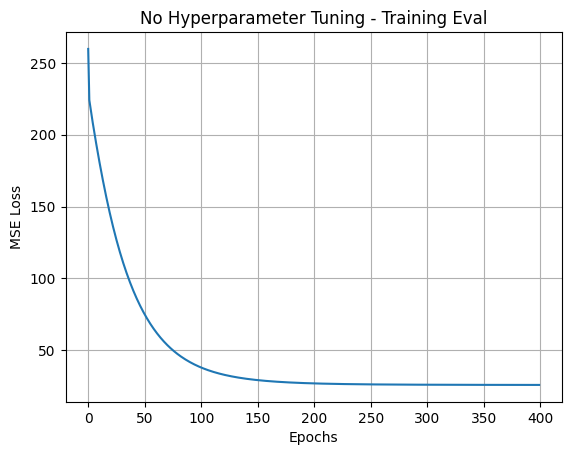

In [54]:
no_hyper_tuning = create_plot(X_axis = range(num_epochs), y_axis = losses, x_label = 'Epochs', y_label = 'MSE Loss', title = 'No Hyperparameter Tuning - Training Eval')
no_hyper_tuning

In [55]:
X_test_scaled = X_test_scaled.astype('float32')
y_test = y_test.astype('float32')

test_model(model, X_test_scaled, y_test, criterion, data_loader_test)

Avg Loss: 15.824455261230469 | Avg Sqrt Loss: 3.977996387784995 | 


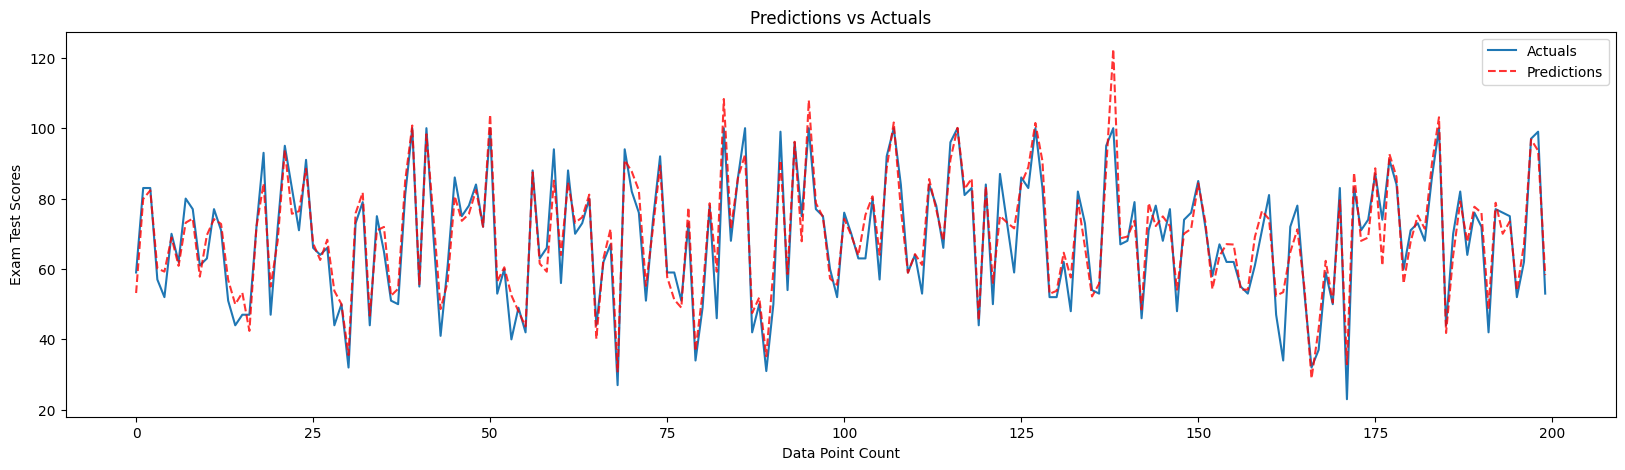

In [56]:
# Visualize predicted values to actual values

inputs = torch.tensor(X_test_scaled.values).to(device)
y_preds = model(inputs)
y_preds = y_preds.cpu().detach().numpy()

plt.figure(figsize=(20, 5))
plt.plot(range(len(X_test)), y_test, label='Actuals')
plt.plot(range(len(X_test)), y_preds, label='Predictions', linestyle='dashed', color='red', alpha=0.8)

plt.legend()
plt.xlabel('Data Point Count')
plt.ylabel('Exam Test Scores')
plt.title('Predictions vs Actuals')
plt.show()

In [57]:
# Save the model (Optional)
path = 'linear_model.pth'

torch.save(model, path)